Min elevation= 42.309349060058594
Max elevation= 3281.4951171875


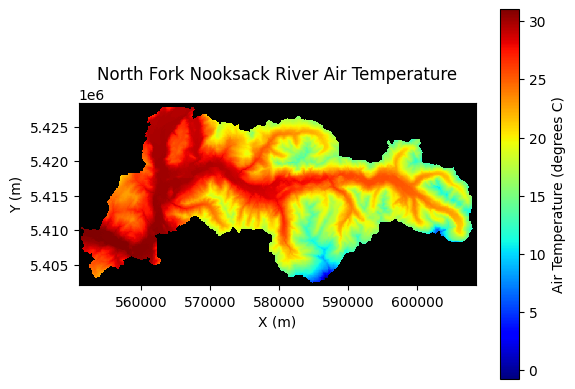

In [1]:
import numpy as np
import xlrd

from landlab import RasterModelGrid
from landlab.components import PotentialEvapotranspiration, Radiation   #Potential Evapotranspiration component 

from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
from landlab.grid.mappers import map_node_to_cell

%matplotlib inline

#from landlab.plot.imshow import imshow_grid
import matplotlib.pyplot as plt

plt.show()


(watershed,Z)=read_esri_ascii('final_nf_90m.asc', name='topographic__elevation')

watershed.set_nodata_nodes_to_closed(Z, -9999.) # here we set nodata to closed boundary

watershed.set_watershed_boundary_condition('topographic__elevation') 
# finds the outlet and closes the watershed boundaries


Ta_o=5;      # degrees oC temperature observed at the lowest point on the watershed (oC)
alpha=9.8      # temperature lapse rate (oC/km) temperature decrease at every km
Tmin_o=25    # Tmin degrees oC temperature observed at the lowest point on the watershed (oC)
Tmax_o=37     # Tmax degrees oC temperature observed at the lowest point on the watershed (oC)

Zmin=np.min(watershed.at_node['topographic__elevation'][watershed.core_nodes])  #let's find the lowest point to scale our lapse rate
Zmax=np.max(watershed.at_node['topographic__elevation'][watershed.core_nodes])  # maximum elevation 

print('Min elevation=', Zmin)
print('Max elevation=', Zmax)

Tmax=Tmax_o-alpha*((Z-Zmin)/10**3)     # calculate your temperatures, note that Ta_o was given for Zmin 
Tmin=Tmin_o-alpha*((Z-Zmin)/10**3)     # calculate your temperatures, note that Ta_o was given for Zmin 
Ta=((Tmin_o+Tmax_o)/2)-alpha*((Z-Zmin)/10**3)     # calculate your temperatures, note that Ta_o was given for Zmin 

_=watershed.add_field('node','air_temperature',Ta, clobber=True)  # add this temperature as a Landlab grid sotred at node property of the grid
_=watershed.add_field('node','min_air_temperature',Tmin, clobber=True)  # add this temperature as a Landlab grid sotred at node property of the grid
_=watershed.add_field('node','max_air_temperature',Tmax, clobber=True)  # add this temperature as a Landlab grid sotred at node property of the grid

## map air temperature across the watershed
imshow_grid(watershed,'air_temperature', plot_name = 'North Fork Nooksack River Air Temperature', 
            var_name = 'Air Temperature', var_units = 'degrees C', grid_units = ('m','m'), cmap = 'jet')

### Using fields of Temperature and LAI node values to compute spatially distributed radiation and PET
After making a PET and a Radiation instance, this code takes previously calculated temperature fields (generated using the lapse rate and node values for topographic elevation) and plugs them into both components, along with a spatially distributed LAI field used for the PET component.

This code demonstrates how both components are capable of taking Temperature, Leaf Area Index, and other node value fields (i.e fields that can be obtained from satellite data, DEMs, other topography information files) and using them for spatially distributed computation.

This code also demonstrates the accuracy of the internal radiation component in PET by displaying PET's generated radiation flux values and Radiation's results side by side.

PET-computed radiation values:

 radiation__net_flux:  95.35604920196597 
 radiation__net_longwave_flux:  19.047219212374735 
 radiation__net_shortwave_flux:  114.40326841434074 
 radiation__ratio_to_flat_surface:  0.4868301665941168 

Radiation-computed radiation values:

 radiation__net_flux:  95.35604920196597 
 radiation__net_longwave_flux:  19.047219212374735 
 radiation__net_shortwave_flux:  114.40326841434074 
 radiation__ratio_to_flat_surface:  0.4868301665941168 



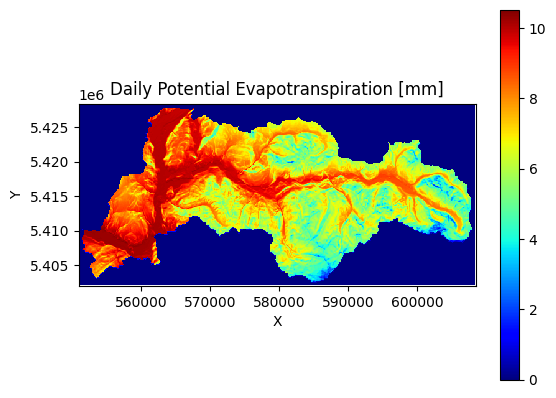

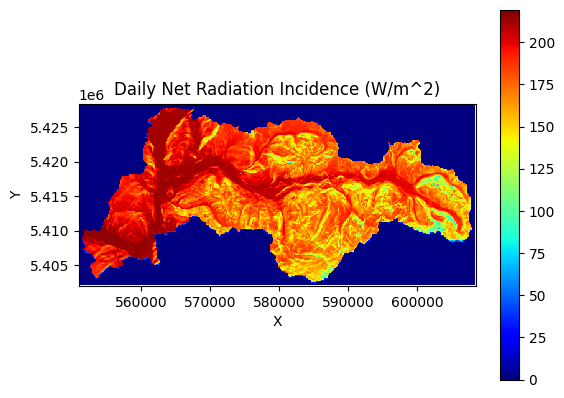

3.811207638245295
95.35604920196597


In [2]:
# Import for commented code block marked "irrefutable proof"
import random 

# Create Temperature and LAI fields with data stored at the NODES.
myTmin = watershed.at_node["min_air_temperature"]
myTmax = watershed.at_node["max_air_temperature"]
myLAI = np.ones(len(watershed.at_node["topographic__elevation"])) * 2.88

# Set up a PET instance
PET = PotentialEvapotranspiration(
    watershed,
    current_time=0.5,
    method="PenmanMonteith",
    albedo=0.12,
    latitude=34.0,
    elevation_of_measurement=2,
    air_density=1220,
    Tmin=myTmin,
    Tmax=myTmax,
    LAI=myLAI,
    Rl=100
)

# Set up a Radiation instance
RAD = Radiation(
    watershed,
    method="Grid",
    latitude=34.0,
    current_time=0.5,
    albedo=0.12,
    max_daily_temp=myTmax,
    min_daily_temp=myTmin,
)

# For irrefutable proof that spatial distribution works, uncomment this section of code
# and observe the results.
# for l in range(len(PET._LAI)):
#     PET._LAI[l] = PET._LAI[l] * random.uniform(0, 10)

# Run updates
RAD.update()
PET.update()

# print all radiation fields from both components to prove no discrepancies exist
print("PET-computed radiation values:\n\n",   
      "radiation__net_flux: ", np.average(PET._etpRad._cell_values["radiation__net_flux"]), "\n",
      "radiation__net_longwave_flux: ", np.average(PET._etpRad._cell_values["radiation__net_longwave_flux"]), "\n",
      "radiation__net_shortwave_flux: ", np.average(PET._etpRad._cell_values["radiation__net_shortwave_flux"]), "\n",
      "radiation__ratio_to_flat_surface: ", np.average(PET._etpRad._cell_values["radiation__ratio_to_flat_surface"]), "\n",
      )

print("Radiation-computed radiation values:\n\n",   
      "radiation__net_flux: ", np.average(RAD._cell_values["radiation__net_flux"]), "\n",
      "radiation__net_longwave_flux: ", np.average(RAD._cell_values["radiation__net_longwave_flux"]), "\n",
      "radiation__net_shortwave_flux: ", np.average(RAD._cell_values["radiation__net_shortwave_flux"]), "\n",
      "radiation__ratio_to_flat_surface: ", np.average(RAD._cell_values["radiation__ratio_to_flat_surface"]), "\n",
      )

plt.figure()
imshow_grid(
    watershed,
    "surface__potential_evapotranspiration_rate",
    values_at="cell",
    plot_name="Daily Potential Evapotranspiration [mm]",
    cmap="jet",
)

plt.figure()
imshow_grid(
    watershed,
    "radiation__net_flux",
    values_at="cell",
    plot_name="Daily Net Radiation Incidence (W/m^2)",
    cmap="jet",
)

plt.show()

print(np.average(watershed["cell"]["surface__potential_evapotranspiration_rate"]))
print(np.average(watershed["cell"]["radiation__net_flux"]))

### Using CONSTANT Temperature and LAI node values to compute NON-spatially distributed radiation and PET
This segment of code demonstrates PET and Radiation component results that use constants, and not spatially distributed factors.

PET-computed radiation values:

 radiation__net_flux:  206.99032190299815 
 radiation__net_longwave_flux:  -92.5870534886574 
 radiation__net_shortwave_flux:  114.40326841434074 
 radiation__ratio_to_flat_surface:  0.4868301665941168 

Radiation-computed radiation values:

 radiation__net_flux:  206.99032190299815 
 radiation__net_longwave_flux:  -92.5870534886574 
 radiation__net_shortwave_flux:  114.40326841434074 
 radiation__ratio_to_flat_surface:  0.4868301665941168 



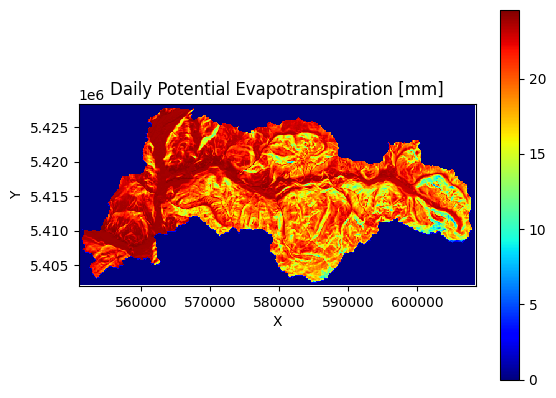

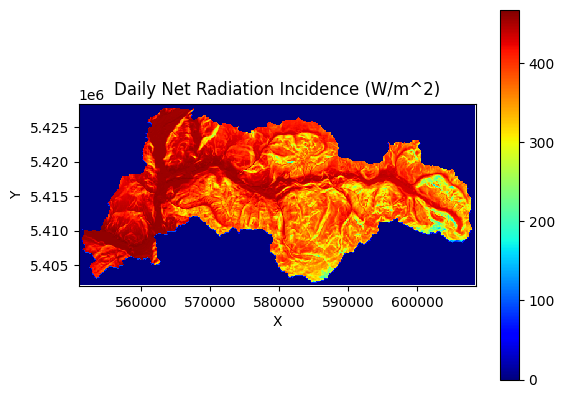

10.732826519445567
206.99032190299815


In [3]:
# Create Temperature and LAI fields with the AVERAGES of the fields we used previously.
# The difference in results should show how averages are NOT as reliable as highly precise,
# spatially distributed node-value fields.
myTmin = np.average( watershed.at_node["min_air_temperature"] )
myTmax = np.average( watershed.at_node["max_air_temperature"] )
myLAI = 2.88

# Set up a PET instance
fixed_PET = PotentialEvapotranspiration(
    watershed,
    current_time=0.5,
    method="PenmanMonteith",
    albedo=0.12,
    latitude=34.0,
    elevation_of_measurement=2,
    air_density=1220,
    Tmin=myTmin,
    Tmax=myTmax,
    LAI=myLAI,
    Rl=100
)

# Set up a Radiation instance
fixed_RAD = Radiation(
    watershed,
    method="Grid",
    latitude=34.0,
    current_time=0.5,
    albedo=0.12,
    max_daily_temp=myTmax,
    min_daily_temp=myTmin,
)

# Run updates
fixed_RAD.update()
fixed_PET.update()

# print all radiation fields from both components to prove no discrepancies exist
print("PET-computed radiation values:\n\n",   
      "radiation__net_flux: ", np.average(fixed_PET._etpRad._cell_values["radiation__net_flux"]), "\n",
      "radiation__net_longwave_flux: ", np.average(fixed_PET._etpRad._cell_values["radiation__net_longwave_flux"]), "\n",
      "radiation__net_shortwave_flux: ", np.average(fixed_PET._etpRad._cell_values["radiation__net_shortwave_flux"]), "\n",
      "radiation__ratio_to_flat_surface: ", np.average(fixed_PET._etpRad._cell_values["radiation__ratio_to_flat_surface"]), "\n",
      )

print("Radiation-computed radiation values:\n\n",   
      "radiation__net_flux: ", np.average(fixed_RAD._cell_values["radiation__net_flux"]), "\n",
      "radiation__net_longwave_flux: ", np.average(fixed_RAD._cell_values["radiation__net_longwave_flux"]), "\n",
      "radiation__net_shortwave_flux: ", np.average(fixed_RAD._cell_values["radiation__net_shortwave_flux"]), "\n",
      "radiation__ratio_to_flat_surface: ", np.average(fixed_RAD._cell_values["radiation__ratio_to_flat_surface"]), "\n",
      )

plt.figure()
imshow_grid(
    watershed,
    "surface__potential_evapotranspiration_rate",
    values_at="cell",
    plot_name="Daily Potential Evapotranspiration [mm]",
    cmap="jet",
)

plt.figure()
imshow_grid(
    watershed,
    "radiation__net_flux",
    values_at="cell",
    plot_name="Daily Net Radiation Incidence (W/m^2)",
    cmap="jet",
)

plt.show()

print(np.average(watershed["cell"]["surface__potential_evapotranspiration_rate"]))
print(np.average(watershed["cell"]["radiation__net_flux"]))

Comparing the averages and grids from the results above, to the results obtained previously, the spatial distribution of factors in both components is readily apparent.